In [5]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from tqdm import trange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as nnf

import matplotlib.pyplot as plt
import pandas as pd

from torchvision import transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import datetime
from tensorflow import summary

import plotly.express as px # для визуализации данных
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image


# Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3070 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [7]:
root = 'data_faces/img_align_celeba_mtcnn'
img_list = os.listdir(root)
print(len(img_list))

202599


In [8]:
mtcnn = MTCNN(image_size=128)

In [9]:
df = pd.read_csv('identity_CelebA.txt', sep='\s+', header=None)
df.to_csv('my_file.csv', header=None)

In [10]:
len(df[1].unique()) # в задаче с буквами, было 1623 различных букв, скрытый слой был 64, тут 10177 различных людей, тогда скрытый слой будет 407, удобнее взять 512

10177

In [11]:
# mtcnn(Image.open("data_faces/img_align_celeba/"+"000199.jpg"))

In [12]:
# cv2.imread("data_faces/img_align_celeba_mtcnn/"+"000199.jpg").shape

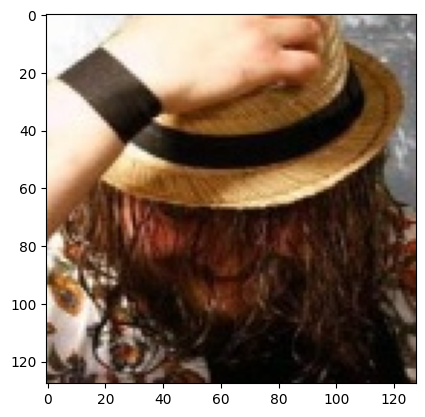

In [13]:
plt.imshow(cv2.imread("data_faces/img_align_celeba_mtcnn/"+"000199.jpg")/255)

In [79]:
count_mtcnn_not_detected = 0
for fname in img_list:
    img = Image.open("data_faces/img_align_celeba/"+fname)
    img = mtcnn(img)
    if img != None:
        img = torch.Tensor(cv2.normalize(img.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)).permute(1,2,0)
        cv2.imwrite("data_faces/img_align_celeba_mtcnn/"+fname, img.numpy()*255)
    else:
        count_mtcnn_not_detected += 1
        img = torch.Tensor(cv2.resize(cv2.cvtColor(cv2.imread("data_faces/img_align_celeba/"+fname), cv2.COLOR_BGR2RGB), (128, 128)))
        img = cv2.normalize(img.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        cv2.imwrite("data_faces/img_align_celeba_mtcnn/"+fname, img*255)
print(f"mtcnn couldn't find {count_mtcnn_not_detected} faces")

mtcnn couldn't find 294 faces


In [14]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        try:
            #print(cls)
            datax_cls = datax[datay == cls]
            perm = np.random.permutation(datax_cls) #возвращает случайную перестановку элементов массива или случайную последовательность заданной длинны из его элементов.
            sample_cls = perm[:(n_support + n_query)]
            #mtcnn_out = [mtcnn(Image.open("data_faces/img_align_celeba/"+fname)) if mtcnn(Image.open("data_faces/img_align_celeba/"+fname)) != None
            #             else torch.Tensor(cv2.resize(cv2.cvtColor(cv2.imread("data_faces/img_align_celeba/"+fname), cv2.COLOR_BGR2RGB)/255, (128, 128))).permute(2,0,1)
            #             for fname in sample_cls]
            #sample.append(torch.stack(mtcnn_out))
            #sample.append(torch.stack([torch.Tensor(cv2.normalize(img.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for img in mtcnn_out]))
            sample.append([cv2.imread(root+"/"+fname)/255
                                    for fname in sample_cls])
            #sample.append(sample_cls)
        except TypeError:
            print([fname for fname in sample_cls], mtcnn_out)
            break
        
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    #sample = torch.stack(sample)
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [15]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

In [16]:
def create_dataset(example: tuple, df): # maximum 35 examples on one label
    df_update = df.loc[df[1].isin((df[1].value_counts()[(example[1] >= df[1].value_counts()) & (df[1].value_counts() >= example[0])]).index)]
    #class_arr = np.random.choice(df_update[1].values, N_class)
    #data_dict = {i: (df_update[df_update[1] == i][0].values) for i in class_arr}
    #data_img = np.array([cv2.imread("data_faces/img_align_celeba/" + picture) for picture in df_update[0].values])
    return df_update[0].values, df_update[1].values

In [17]:
trainx, trainy = create_dataset((15,30), df)

In [18]:
testx, testy = create_dataset((31,35), df)

In [19]:
trainx.shape, testx.shape

((181604,), (548,))

In [20]:
len(np.unique(trainy)), len(np.unique(testy))

(7400, 17)

In [21]:
sample_example = extract_sample(5, 3, 3, trainx, trainy)

In [22]:
sample_example['images'][0].mean()

tensor(0.4992)

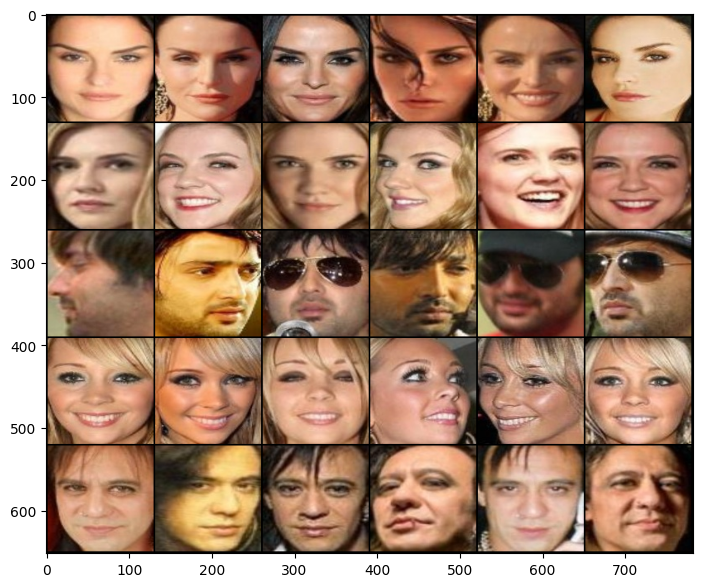

In [23]:
display_sample(sample_example['images'])

In [17]:
# img =  [Image.open("data_faces/img_align_celeba/000001.jpg", ), Image.open("data_faces/img_align_celeba/000002.jpg")]

# # Get cropped and prewhitened image tensor
# img_cropped = mtcnn(img) #mtcnn(img, save_path="img_cropped.jpg")

# # Calculate embedding (unsqueeze to add batch dimension)
# img_embedding = resnet(torch.stack(img_cropped))

# # Or, if using for VGGFace2 classification
# #resnet.classify = True
# #img_probs = resnet(img_cropped.unsqueeze(0))

In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.encode = InceptionResnetV1(pretrained='vggface2')
        
    def forward(self, inp):
        return self.encode(inp)

In [25]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.to(device)

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images'].to(device)
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        
        # pass your code
        # была таблица картинок, мы её развернули в одномерный массив картинок и вязли в support и query нужное число картинок
        x_support, x_query = sample_images[:,:n_support].reshape(n_way*n_support, 3, 128, 128), sample_images[:, n_support:].reshape(n_way*n_query, 3, 128, 128)

        x_support = self.encoder(x_support) # получили векторное представление картинок теперь размерность (число картинок * выход из последнего слоя (скорее всего 64))
        x_support = x_support.reshape(n_way, n_support, x_support.shape[-1]) # чтобы найти "опорные" объекты, нужно разжать массив, чтобы в одной из размерности было n_support
        # и по ним всзять среднее 
        x_prototype = x_support.mean(1)

        x_query = self.encoder(x_query) 

        n, m = x_query.shape
        l = x_prototype.shape[0]

        # у нас получилсиь тензоры с разными размерностями, чтобы найти расстояние между ними, нужно продублировать их значения, чтобы размерности совпали
        # (было 300*64) and (60*64) => добавим первому ширины, в второму длины
        # .sum(2) - евклидово расстояние, нужно складывать разность между соответствующими координатами, а в данном случае между 64 признаками
        dists = torch.pow(x_query.unsqueeze(1).expand(n, l, m)- x_prototype.expand(n, l, m), 2).sum(2) 

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long() # сделали для каждого элемента из n_way индексы меток, которые будем предсказывать
        target_inds = Variable(target_inds, requires_grad=False) # чтобы можно было брать градиенты, хотя теперь так не пишут
        target_inds = target_inds.to(device)

        log_p_y = nn.LogSoftmax(dim=-1)(-dists).reshape(n_way, n_query, n_way) # я интерпертирую изменение размерности так: у нас 60 различных букв (n_way)
        # каждой такой букве соответствует n_query её представителей, и мы хотим для каждого представителя найти вероятность с которой он принадлежит к каждой из n_way букв, которую она представляет
        # хотя потом всё равно берём log

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        #print(loss_val, log_p_y.gather(2, target_inds).squeeze().shape)
        _, y_hat = log_p_y.max(2) # вторым аргументов возвращает индексы, т.е. номер класса, к которому с наибольшей вероятностью принадлежит объект
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

        # log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
        # loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        # _, y_hat = log_p_y.max(2)
        # acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
            }

In [26]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Encoder() # your code

    return ProtoNet(encoder)

In [120]:
%load_ext tensorboard

In [121]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    current_time = str(datetime.datetime.now().timestamp())
    train_log_dir = 'logs/tensorboard/train/' + current_time
    #test_log_dir = 'logs/tensorboard/test/' + current_time
    train_summary_writer = summary.create_file_writer(train_log_dir)
    #test_summary_writer = summary.create_file_writer(test_log_dir)

    globaliter = 0
    log_interval = 200
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in trange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

            globaliter += 1
            if globaliter % log_interval == 0:
              # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              #           epoch, batch_idx * len(data), len(self.train_loader.dataset),
              #           100. * batch_idx / len(self.train_loader), loss.item()))
            
              with train_summary_writer.as_default():
                    summary.scalar('loss', output['loss'], step=globaliter)
                    summary.scalar('accuracy', output['acc'], step=globaliter)
        
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

In [3]:
model_loaded

NameError: name 'model_loaded' is not defined

In [30]:
model = load_protonet_conv(
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 20
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5 # 5
epoch_size = 2000

In [31]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 5.9824e-02,  1.7953e-01,  2.8926e-01],
           [-3.7600e-02,  7.0271e-02,  1.3611e-01],
           [-2.1849e-01, -8.6169e-02, -1.3002e-02]],
 
          [[ 2.2355e-02,  1.8516e-01,  3.1012e-01],
           [-9.2252e-02,  5.4475e-02,  1.4013e-01],
           [-3.0034e-01, -1.3172e-01, -3.9770e-02]],
 
          [[ 9.2837e-02,  2.0002e-01,  3.2233e-01],
           [-1.8695e-02,  7.3924e-02,  1.5134e-01],
           [-2.5090e-01, -1.1609e-01, -3.9765e-02]]],
 
 
         [[[-2.0792e-01, -9.2688e-02, -9.4617e-02],
           [ 1.2252e-02,  7.9317e-02,  8.9089e-02],
           [ 1.5763e-01,  2.2229e-01,  2.7606e-01]],
 
          [[-2.4610e-01, -1.2089e-01, -1.3046e-01],
           [-3.9564e-03,  7.9825e-02,  8.5580e-02],
           [ 1.2087e-01,  2.0506e-01,  2.5370e-01]],
 
          [[-2.1682e-01, -1.2305e-01, -1.3316e-01],
           [ 1.1448e-02,  5.7706e-02,  6.2719e-02],
           [ 2.0375e-01,  2.4775e-01,  3.0523e-01]]],
 
 
         [[[-1.39

In [128]:
# next(model.parameters()).is_cpu

In [40]:
# import torch
torch.cuda.empty_cache()

In [129]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [13:14<00:00,  2.52it/s]


Epoch 1 -- Loss: 1.8098 Acc: 0.6869


Epoch 2 train: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [08:50<00:00,  3.77it/s]


Epoch 2 -- Loss: 1.6751 Acc: 0.8030


Epoch 3 train: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [08:33<00:00,  3.90it/s]


Epoch 3 -- Loss: 1.6051 Acc: 0.8522


Epoch 4 train: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [08:29<00:00,  3.92it/s]


Epoch 4 -- Loss: 1.5450 Acc: 0.8928


Epoch 5 train: 100%|█████████████████████████████████████████████████████████████| 2000/2000 [1:01:38<00:00,  1.85s/it]

Epoch 5 -- Loss: 1.5072 Acc: 0.9163
CPU times: total: 3h 25min 21s
Wall time: 1h 40min 45s


In [130]:
torch.save(model.state_dict(), "trained_model_facenet")

In [29]:
list(model_loaded.parameters())

[Parameter containing:
 tensor([[[[ 4.7857e-02,  1.7637e-01,  2.9100e-01],
           [-5.7431e-02,  6.1378e-02,  1.3493e-01],
           [-2.4486e-01, -1.0706e-01, -2.6659e-02]],
 
          [[-1.6451e-02,  1.5796e-01,  2.9031e-01],
           [-1.2822e-01,  3.4271e-02,  1.3078e-01],
           [-3.3366e-01, -1.5725e-01, -5.6044e-02]],
 
          [[ 7.9741e-02,  1.9976e-01,  3.2899e-01],
           [-3.9116e-02,  6.5650e-02,  1.5298e-01],
           [-2.8171e-01, -1.3905e-01, -5.5088e-02]]],
 
 
         [[[-2.2673e-01, -1.0721e-01, -1.1425e-01],
           [ 2.2001e-03,  7.4384e-02,  7.9846e-02],
           [ 1.5484e-01,  2.2810e-01,  2.7801e-01]],
 
          [[-2.7646e-01, -1.4985e-01, -1.6268e-01],
           [-3.5530e-02,  5.1074e-02,  5.3974e-02],
           [ 8.3110e-02,  1.7520e-01,  2.2200e-01]],
 
          [[-2.3914e-01, -1.4229e-01, -1.5465e-01],
           [ 1.0518e-03,  5.1905e-02,  5.5528e-02],
           [ 2.0833e-01,  2.6115e-01,  3.1877e-01]]],
 
 
         [[[-3.46

In [27]:
model_loaded = load_protonet_conv(x_dim=(3, 128, 128),
    hid_dim=128,
    z_dim=128,)
model_loaded.load_state_dict(torch.load("trained_model_facenet"))
model_loaded.eval().to(device)

ProtoNet(
  (encoder): Encoder(
    (encode): InceptionResnetV1(
      (conv2d_1a): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2d_2a): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (conv2d_2b): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2d_3b): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [133]:
%tensorboard --logdir logs/tensorboard

In [134]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in trange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [135]:
n_way = 10
n_support = 1
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [136]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [137]:
test(model_loaded, test_x, test_y, n_way, n_support, n_query, test_episode) # was 01:13

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.14it/s]

Test results -- Loss: 1.2323 Acc: 0.7147


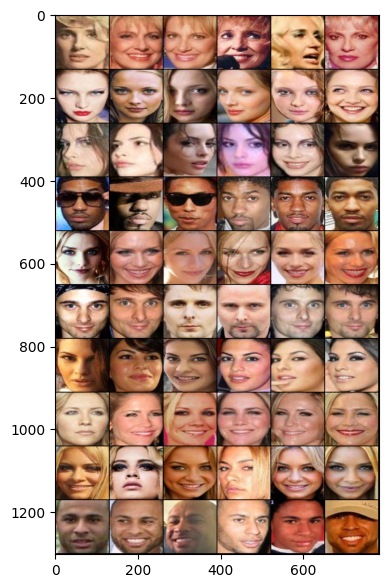

In [138]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [139]:
my_loss, my_output = model_loaded.set_forward_loss(my_sample)

In [140]:
my_output

{'loss': 1.2671581506729126,
 'acc': 0.699999988079071,
 'y_hat': tensor([[0, 0, 0, 7, 0],
         [1, 1, 1, 1, 1],
         [6, 6, 1, 2, 1],
         [3, 9, 3, 3, 3],
         [4, 4, 4, 1, 8],
         [5, 5, 5, 5, 5],
         [6, 6, 6, 6, 6],
         [8, 7, 7, 8, 7],
         [1, 8, 1, 8, 1],
         [3, 3, 9, 9, 9]], device='cuda:0')}

In [299]:
def test_batch(my_test_path="my_test_images", batch_list = None): # first is support
    if batch_list == None:
        batch_list = []
    for fname in os.listdir(my_test_path):
        img = Image.open(my_test_path+"/"+fname)
        img = mtcnn(img)
        if img != None:
            img = torch.Tensor(cv2.normalize(img.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)).permute(1,2,0)
        else:
            img = torch.Tensor(cv2.resize(cv2.cvtColor(cv2.imread("my_img/"+fname), cv2.COLOR_BGR2RGB), (128, 128)))
            img = cv2.normalize(img.numpy(), None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        batch_list.append(img.numpy())
    return batch_list

In [403]:
my_img = test_batch("my_img")
my_img = test_batch("my_test_images", my_img)

In [404]:
for fname in np.random.choice(np.unique(testx), 10, replace=False):
    my_img.append(cv2.imread("data_faces/img_align_celeba_mtcnn/"+fname)/255)

In [405]:
len(my_img)

22

In [406]:
my_img = np.array(my_img)
my_img = torch.from_numpy(my_img).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


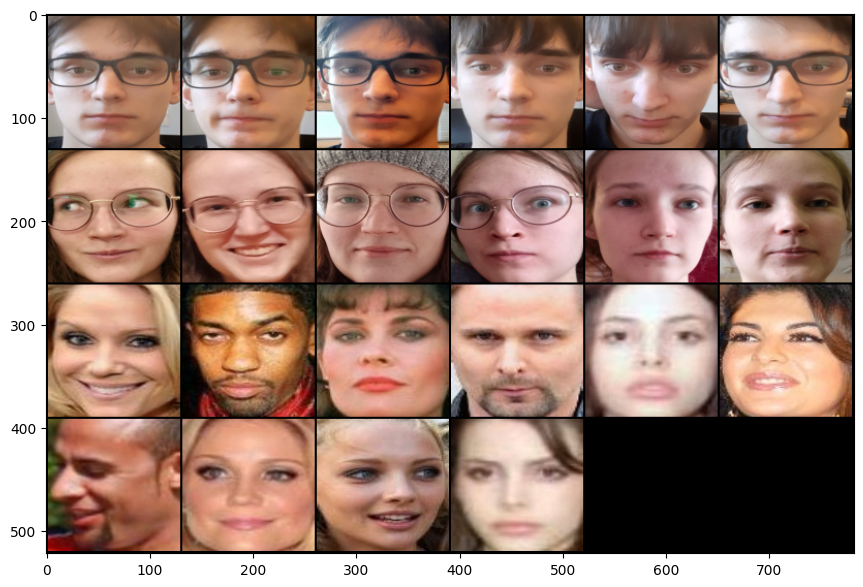

In [407]:
sample_4D = my_img.view(my_img.shape[0], *my_img.shape[1:])
sample_4D=sample_4D.permute(0,3,1,2)
out = torchvision.utils.make_grid(sample_4D, nrow=6)

plt.figure(figsize=(16, 7))
plt.imshow(out.permute(1,2,0))

In [408]:
my_support = my_img[0].permute(2,0,1).unsqueeze(0).to(device)
my_query = my_img[1:].permute(0, 3, 1, 2).to(device)

In [409]:
my_support_emb = model_loaded.encoder(my_support)
my_query_emb = model_loaded.encoder(my_query)

In [410]:
#embed = TSNE(n_components=2, perplexity=5)
X = np.concatenate((my_support_emb.cpu().detach().numpy(), my_query_emb.cpu().detach().numpy()))
#X_embedded = embed.fit_transform(X)

In [418]:
# clustering = DBSCAN(eps=6.2, min_samples=1).fit(X)
clustering = DBSCAN(eps=0.6, min_samples=1)#.fit(X)
clustering.core_sample_indices_ = np.array([0])
clustering.fit(X)

DBSCAN(eps=0.6, min_samples=1)

In [419]:
# labels = kmean.labels_
labels = clustering.labels_

In [420]:
my_img[my_img < 0.001] = 0

In [421]:
my_img.min()

tensor(0.)

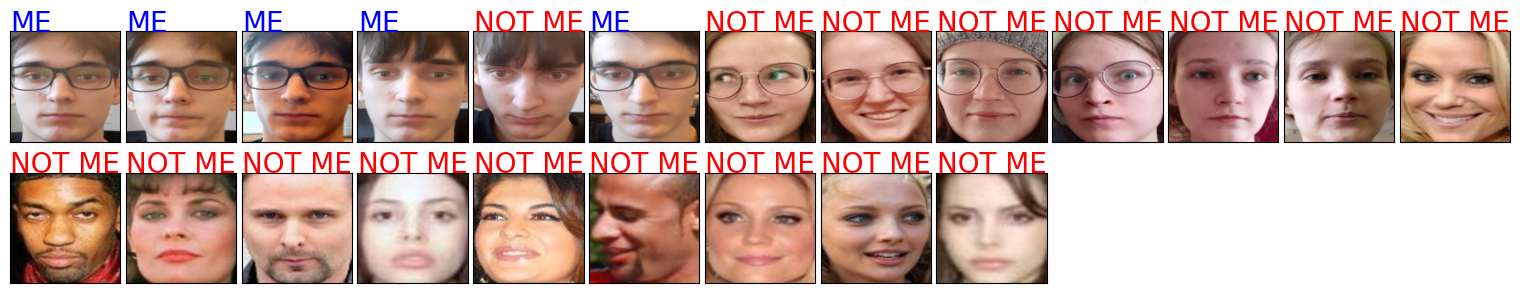

In [422]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(len(my_img)):
    ax = fig.add_subplot(5, 13, i + 1, xticks=[], yticks=[])
    ax.imshow(sample_4D[i].permute(1, 2, 0))

    if labels[i] == labels[0]:
        ax.text(0, 0, "ME", color='blue', fontsize = 20)
    else:
        ax.text(0, 0, "NOT ME", color='red', fontsize = 20)

In [416]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 4, 1, 6, 5],
      dtype=int64)

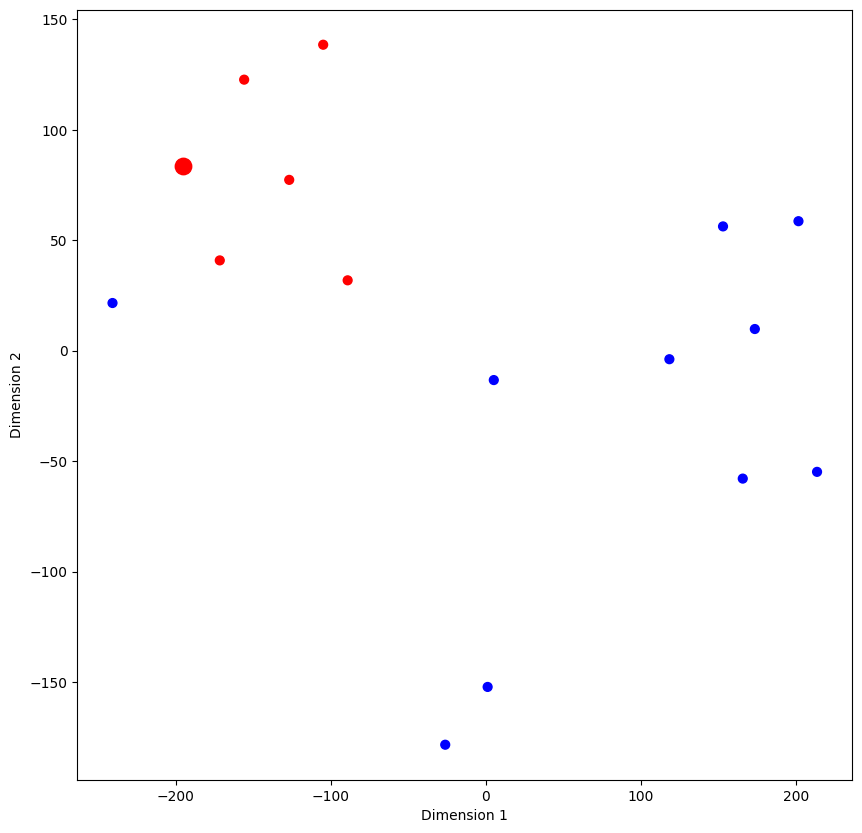

In [417]:
colors = np.random.rand(1)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.scatter(x=X_embedded[:1,0], y=X_embedded[:1,1], c='red', s=140)
plt.scatter(x=X_embedded[1:6,0], y=X_embedded[1:6,1], c=np.repeat('red', 5), s=40)
plt.scatter(x=X_embedded[6:16,0], y=X_embedded[6:16,1], c=np.repeat('blue', 10), s=40)
plt.show()

In [256]:
print(f"shape of latent space: {my_support_emb.shape[1]}")

shape of latent space: 512


In [ ]:
cv2.resize(cv2.cvtColor(cv2.imread("data_faces/img_align_celeba/"+), cv2.COLOR_BGR2RGB), (128, 128)

In [27]:
def visual_predict(sample, model):
    sample_images = sample['images'].to(device)
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    # pass your code
    # была таблица картинок, мы её развернули в одномерный массив картинок и вязли в support и query нужное число картинок
    x_support, x_query = sample_images[:,:n_support].reshape(n_way*n_support, 3, 128, 128), sample_images[:, n_support:].reshape(n_way*n_query, 3, 128, 128)
    x_support = model.encoder(x_support) # получили векторное представление картинок теперь размерность (число картинок * выход из последнего слоя (скорее всего 64))
    x_support = x_support.reshape(n_way, n_support, x_support.shape[-1]) # чтобы найти "опорные" объекты, нужно разжать массив, чтобы в одной из размерности было n_support
    # и по ним всзять среднее 
    x_prototype = x_support.mean(1)
    x_query = model.encoder(x_query) 

    n_prototype = x_prototype.shape[0]
    # t-SNE ---------------------------------------------
    embed = TSNE(n_components=2, perplexity=5)
    # Преобразование X
    print(x_prototype.shape, x_query.shape)
    X = np.concatenate((x_prototype.cpu().detach().numpy(), x_query.cpu().detach().numpy()))
    X_embedded = embed.fit_transform(X)
    print(X.shape, n_query)
    # Вывод результатов
    print('New Shape of X: ', X_embedded.shape)
    print('Kullback-Leibler divergence after optimization: ', embed.kl_divergence_)
    print('No. of iterations: ', embed.n_iter_)
    #вывод('Embedding vectors: ', embed.embedding_)

    # visual -------------------------------------------------
    colors = np.random.rand(n_prototype)
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.scatter(x=X_embedded[:n_prototype,0], y=X_embedded[:n_prototype,1], c=colors, s=140)
    plt.scatter(x=X_embedded[n_prototype:,0], y=X_embedded[n_prototype:,1], c=np.repeat(colors, n_query), s=40)
    plt.show()

torch.Size([5, 8192]) torch.Size([25, 8192])
(30, 8192) 5
New Shape of X:  (30, 2)
Kullback-Leibler divergence after optimization:  0.3365040123462677
No. of iterations:  999


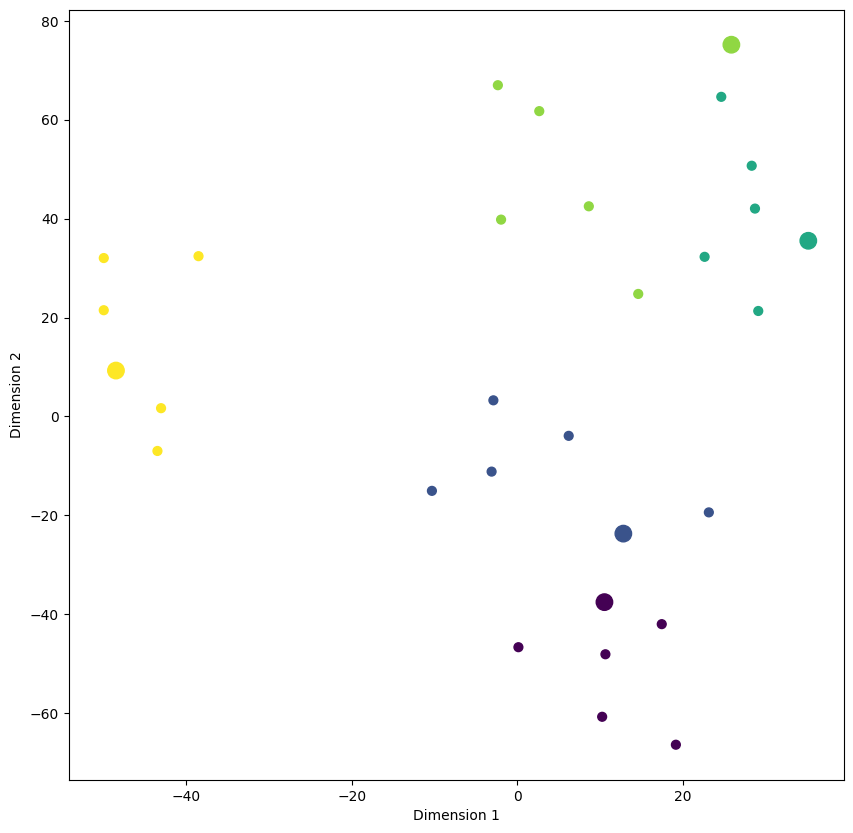

In [29]:
visual_predict(my_sample, model_loaded)

In [418]:
class conv_block_update(nn.Module):
    def __init__(self, input_c, out_c):
        super().__init__() 

        self.block = nn.Sequential(
            nn.Conv2d(input_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self, inp):
        return self.block(inp)

class Encoder_update(nn.Module):
    def __init__(self, input_c, out_c, hid_dim):
        super().__init__() 

        self.encode = nn.Sequential(
            conv_block_update(input_c,hid_dim),
            conv_block_update(hid_dim,hid_dim),
            conv_block_update(hid_dim,hid_dim),
            conv_block_update(hid_dim,hid_dim),
            #conv_block_update(hid_dim,hid_dim),
            conv_block_update(hid_dim,out_c),
            nn.Flatten()
        )
    def forward(self, inp):
        return self.encode(inp)

In [419]:
Encoder_update(3, 128, 128)(my_support.cpu()).shape

torch.Size([1, 2048])

In [186]:
df.loc[df[1].isin((df[1].value_counts()[df[1].value_counts() == 20]).index)][1]

12        3785
16         667
28        3422
31         268
48        6817
          ... 
202557    6287
202562    7045
202584    6758
202585    7037
202588    7982
Name: 1, Length: 20880, dtype: int64

In [ ]:
class Dataset(Dataset):
    def __init__(self, N_class, min_example, df, transform=None):
        self.N_class = N_class
        self.min_example = min_example
        self.data = create_dataset(N_class, min_example, df)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        if self.transform is not None:
            image = self.transform(image)
        return image

In [117]:
df

0      1
0       000001.jpg   2880
1       000002.jpg   2937
2       000003.jpg   8692
3       000004.jpg   5805
4       000005.jpg   9295
...            ...    ...
202594  202595.jpg   9761
202595  202596.jpg   7192
202596  202597.jpg   9852
202597  202598.jpg   5570
202598  202599.jpg  10101

[202599 rows x 2 columns]

In [98]:
df[1].values in np.array((df[1].value_counts() > 10).index)

C:\Users\mrsaf\AppData\Local\Temp\ipykernel_8368\3400230050.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  df[1].values in np.array((df[1].value_counts() > 10).index)


False

In [102]:
df[1]

0          2880
1          2937
2          8692
3          5805
4          9295
          ...  
202594     9761
202595     7192
202596     9852
202597     5570
202598    10101
Name: 1, Length: 202599, dtype: int64

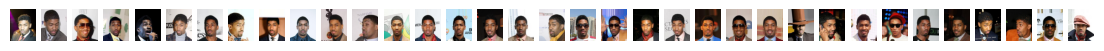

In [74]:
pic_box = plt.figure(figsize=(16,4))
 
# Поочередно считываем в переменную picture имя изображения из списка pictures. В переменную i записываем номер итерации
for i, picture in enumerate(df[df[1]==3227][0].values):
    # считываем изображение в picture
    picture = cv2.imread("data_faces/img_align_celeba/" + picture)
    # конвертируем BGR изображение в RGB
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    # добавляем ячейку в pix_box для вывода текущего изображения
    pic_box.add_subplot(1,40,i+1)
    plt.imshow(picture)
    # отключаем отображение осей
    plt.axis('off')
# выводим все созданные фигуры на экран
plt.show()    

000023.jpg
004506.jpg
006439.jpg
014042.jpg
015216.jpg
023004.jpg
024091.jpg
027827.jpg
030454.jpg
032404.jpg
033490.jpg
049381.jpg
051162.jpg
056279.jpg
064538.jpg
067807.jpg
067855.jpg
068169.jpg
087503.jpg
090781.jpg
108998.jpg
111433.jpg
112544.jpg
117150.jpg
130350.jpg
142586.jpg
142874.jpg
145590.jpg
157602.jpg


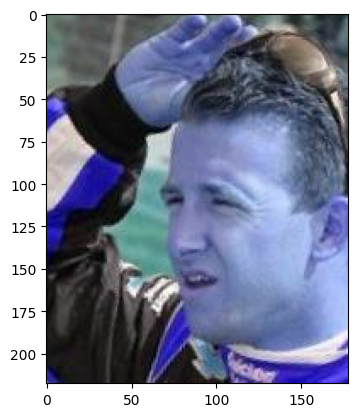

In [47]:
for i in df[df[1]==1][0].values:
    print(i)
    plt.imshow(cv2.imread("data_faces/img_align_celeba/"+i))#.shape

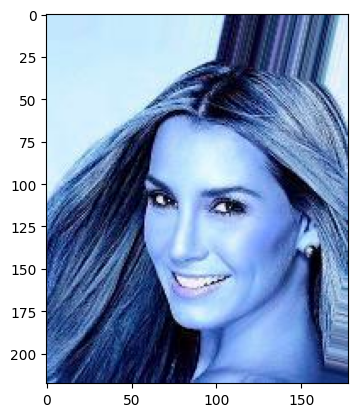

In [45]:
plt.imshow(cv2.imread("data_faces/img_align_celeba/000001.jpg"))#.shape